### This notebook contains all the code needed to develop a customized environment and train/validation.
Once finish, should put them separately into project folder. Putting them in this single notebook is just for convenience to run in Colab.

### change sys.path.append() based on your mounting path. The .ipynb is located within newgymrepo-Main/gym-sokoban/

In [ ]:
import sys

sys.path.append('/content/drive/MyDrive/gym-sokoban/')
base_dir = "/content/drive/MyDrive/gym-sokoban"
log_file_name = "/content/sokoban_env.txt"

from google.colab import drive
drive.mount('/content/drive')


# sys.path.append("/Users/evansun/Documents/Claudia/CS5446 AI_planning_decision_making/project/my-gym-repo/otherRepo/gym-sokoban-default")
# base_dir = "/Users/evansun/Documents/Claudia/CS5446 AI_planning_decision_making/project/my-gym-repo/otherRepo/gym-sokoban-default"
# log_file_name = base_path + "/" + "sokoban_log.txt"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install gym
!pip install stable_baselines3
!pip install Shimmy

## generate maps (only run when necessary)

In [ ]:

import numpy as np
import os
import sys
import shutil



# Constants for tile types
FLOOR   = 0
WALL    = 1
BOX     = 2
TARGET  = 3
BOX_ON_TARGET = 4  # not used in generation directly
PLAYER  = 5

BOARD_WIDTH = 10
BOARD_HEIGHT = 10

def generate_base_map(width=10, height=10, difficulty=1):
    """
    Create a grid with walls on the borders and floor in the interior.
    """
    if difficulty < 4:
        board = np.zeros((height, width), dtype=int)
        board[0:3, :] = WALL
        board[height-3:height, :] = WALL
        board[:, 0:3] = WALL
        board[:, width-3:width] = WALL
    elif difficulty < 7:
        board = np.zeros((height, width), dtype=int)
        board[0:2, :] = WALL
        board[height-2:height, :] = WALL
        board[:, 0:2] = WALL
        board[:, width-2:width] = WALL
    else:
        board = np.zeros((height, width), dtype=int)
        board[0, :] = WALL
        board[-1, :] = WALL
        board[:, 0] = WALL
        board[:, -1] = WALL
    return board

def add_random_walls(board, wall_density):
    """
    Fill internal cells (not borders) with walls randomly according to the density.

    Parameters:
      board: the base map
      wall_density: a float (0 to 1) representing the probability of placing a wall
    """
    height, width = board.shape
    for i in range(1, height-1):
        for j in range(1, width-1):
            # Only add a wall if the cell is not already a wall.
            if board[i, j] == FLOOR and np.random.random() < wall_density:
                board[i, j] = WALL
    return board

def place_elements(board, n_boxes, n_targets):
    """
    Randomly place a single player, boxes, and targets in available floor spaces.

    The function assumes that there is enough space.
    """
    free_positions = list(zip(*np.where(board == FLOOR)))
    if len(free_positions) < (n_boxes + n_targets + 1):
        raise ValueError("Not enough free cells to place all elements.")

    # Shuffle the list so placements are random.
    np.random.shuffle(free_positions)

    # Place the player first:
    player_pos = free_positions.pop()
    board[player_pos] = PLAYER

    # Place boxes:
    boxes = []
    for _ in range(n_boxes):
        pos = free_positions.pop()
        board[pos] = BOX
        boxes.append(pos)

    # Place targets:
    targets = []
    for _ in range(n_targets):
        pos = free_positions.pop()
        board[pos] = TARGET
        targets.append(pos)

    return board, player_pos, boxes, targets

def choose_map(map_path, difficulty):
    """
    Load Sokoban puzzles with human solutions from text files.

    Args:
        directory_path: Path to directory containing puzzle files

    Returns:
        list of tuples: (puzzle_state, solution_moves)
    """
    puzzle = []

    file_list = []
    for filename in os.listdir(map_path):
        # choose the .txt file with the specified difficulty level
        if not filename.endswith('.txt') or not filename.startswith(str(difficulty) + "_"):
            continue

        file_list.append(filename)

    chosen_filename = random.choice(file_list)

    filepath = os.path.join(map_path, chosen_filename)
    # print(filepath)
    with open(filepath, 'r') as f:
        for line in f:
            content = line.strip()
            if "#" in content:
                puzzle.append(content)
            elif content.strip() != "":
                solution = content
        # # Split content into puzzle and solution
        # lines = content.strip().split('\n')
        # puzzle_lines = [line for line in lines if line and '#' in line]
        # solution = lines[-1].strip() if lines[-1].strip() and not '#' in lines[-1] else ""

        # # Convert puzzle to standard format
        # puzzle_str = '\n'.join(puzzle_lines)
        # break

    return puzzle, solution, chosen_filename


def generate_map(width, height, difficulty):
    """
    Generate one Sokoban map based on the specified difficulty.

    The difficulty parameter is used to tweak:
      - number of boxes (and targets)
      - wall density (more walls → more obstacles)

    You can adjust the parameters as needed.
    """
    if difficulty == 1:
        n_boxes = 1
        wall_density = 0.0  # No extra obstacles
        n_targets = 1
    elif difficulty == 2:
        n_boxes = 1
        wall_density = 0.05  # Sparse obstacles
        n_targets = 1
    elif difficulty == 3:
        n_boxes = 1
        wall_density = 0.05  # A few obstacles to force slight navigation issues
        n_targets = 1
    elif difficulty == 4:
        n_boxes = 2
        wall_density = 0.0  # More obstacles in the field
        n_targets = 2
    elif difficulty == 5:
        n_boxes = 2
        wall_density = 0.05  # Dense obstacles, which can lead to tricky deadlock situations
        n_targets = 2
    elif difficulty == 6:
        n_boxes = 3
        wall_density = 0.0  # Dense obstacles, which can lead to tricky deadlock situations
        n_targets = 3
    elif difficulty == 7:
        n_boxes = 2
        wall_density = 0.05  # Dense obstacles, which can lead to tricky deadlock situations
        n_targets = 2
    elif difficulty == 8:
        n_boxes = 2
        wall_density = 0.05  # Dense obstacles, which can lead to tricky deadlock situations
        n_targets = 3
    else:
        raise ValueError("Unknown difficulty level.")

    # Create the base board (you can also vary width/height if desired)
    board = generate_base_map(width, height, difficulty)
    board = add_random_walls(board, wall_density)
    board, player, boxes, targets = place_elements(board, n_boxes, n_targets)
    return board

def convert_to_deepmind_format(board):
    map = ""
    # print(board)
    for i in range(BOARD_HEIGHT):
        line = ""
        for j in range(BOARD_WIDTH):
            if board[i][j] == WALL:
                line += "#"
            elif board[i][j] == FLOOR:
                line += " "
            elif board[i][j] == PLAYER:
                line += "@"
            elif board[i][j] == BOX:
                line += "$"
            elif board[i][j] == TARGET:
                line += "."
        line += "\n"
        map += line
    return map


def delete_files_in_directory(directory_path):
   try:
     shutil.rmtree(directory_path)
     print("All files deleted successfully.")
   except OSError:
     print("Error occurred while deleting files.")



In [ ]:
import time
import numpy as np
from PIL import Image, ImageFont, ImageDraw
import base64
from IPython.display import HTML
import imageio

## from Sarjune's code

def create_gif(observations, filename="sokoban.gif", success=False, is_maxsteps = False):
    """Create GIF from observations"""
    if not observations:
        print("No observations to visualize")
        return

    images = []
    total_frames = len(observations)
    for i in range(total_frames):

        # Get observation and ensure correct format
        obs = observations[i]
        if len(obs.shape) == 3 and obs.shape[0] == 3:  # (C, H, W) format
            obs = np.transpose(obs, (1, 2, 0))  # Convert to (H, W, C)

        # Create PIL image
        img = Image.fromarray(obs.astype('uint8'))

        if i == total_frames-1:
            Im = ImageDraw.Draw(img)
            if success:
                Im.text((20, 20), "Success!",fill=(255, 255, 255))
            else:
                if is_maxsteps:
                    Im.text((50, 30), "Fail! max_steps!",fill=(255, 255, 255))
                else:
                    Im.text((50, 30), "Fail! push to corner",fill=(255, 255, 255))
        images.append(img)


    # Save as GIF
    if images:
        images[0].save(
            filename,
            save_all=True,
            append_images=images[1:],
            # duration=100//fps,
            loop=1
        )
        print(f"GIF saved to {filename}")

    else:
        print("No images to create GIF")



## Customize_boxoban_env.py


In [ ]:
import gym
from gym import spaces
from gym.utils import seeding
from gym.spaces.discrete import Discrete
from gym.spaces import Box

import gym_sokoban.envs.room_utils as room_utils
# from .render_utils import room_to_rgb, room_to_tiny_world_rgb
# import numpy as np
import gym_sokoban.envs.sokoban_env as sokoban_env
from gym_sokoban.envs.render_utils import room_to_rgb, room_to_tiny_world_rgb

# from .boxoban_env import BoxobanEnv
# from .render_utils import room_to_rgb
import os
from os import listdir
from os.path import isfile, join
import requests
import zipfile
from tqdm import tqdm
import random
import numpy as np



ACTION_LOOKUP = {
    0: 'no operation',
    1: 'push up',
    2: 'push down',
    3: 'push left',
    4: 'push right',
    5: 'move up',
    6: 'move down',
    7: 'move left',
    8: 'move right',
}

# Moves are mapped to coordinate changes as follows
# 0: Move up
# 1: Move down
# 2: Move left
# 3: Move right
CHANGE_COORDINATES = {
    0: (-1, 0),
    1: (1, 0),
    2: (0, -1),
    3: (0, 1)
}

RENDERING_MODES = ['rgb_array', 'human', 'tiny_rgb_array', 'tiny_human', 'raw']


def manhattan_distance(p1, p2):
    return abs(p1[0] - p2[0]) + abs(p1[1] - p2[1])

class CustomizeSokobanEnv(gym.Env):
    metadata = {
        'render.modes': ['human', 'rgb_array', 'tiny_human', 'tiny_rgb_array', 'raw'],
        'render_modes': ['human', 'rgb_array', 'tiny_human', 'tiny_rgb_array', 'raw']
    }

    def __init__(self,
                 dim_room=(10, 10),
                 max_steps=100,
                 num_boxes=1,
                 num_gen_steps=None,
                 reset=True,
                 difficulty ="medium",
                 split="train",
                 verbose = True,
                 ):
        super().__init__()

        # General Configuration
        self.dim_room = dim_room
        if num_gen_steps == None:
            self.num_gen_steps = int(1.7 * (dim_room[0] + dim_room[1]))
        else:
            self.num_gen_steps = num_gen_steps

        self.num_boxes = num_boxes
        self.difficulty = difficulty
        self.split = split
        self.verbose = verbose
        self.cache_path = os.path.join(base_dir, ".sokoban_cache")

        # represent the total reward for the episode!!
        self.reward_last = 0

        # Other Settings
        self.viewer = None
        self.max_steps = max_steps
        self.action_space = Discrete(len(ACTION_LOOKUP))
        screen_height, screen_width = (dim_room[0] * 16, dim_room[1] * 16)
        self.observation_space = Box(low=0, high=255, shape=(screen_height, screen_width, 3), dtype=np.uint8)


        # Define reward values - adjusted for better learning
        self.reward_box_on_target = 2.0     # Increase (was 5.0)
        self.reward_box_closer = 0.2         # Increase (was 0.5)
        self.reward_puzzle_solved = 10.0     # Larger reward for solving
        self.reward_exploration_bonus = 0.5       # Small bonus for trying new states
        self.reward_player_explore = 3
        self.reward_box_closer = 0.1

        self.penalty_box_deadend = -10    # Penalty for corner situations
        self.penalty_for_step = -0.05          # Reduce (was -0.001)
        self.penalty_repeat_walk_around = -0.2
        self.penalty_invalid_action = -0.05


        # extra state tracking to use in reward calculation
        self.last_step_push_box = 0
        self.boxes_on_target = 0
        self.box_distances = -1
        self.visited_states = []  # Track visited states
        self.player_visited_pos = []
        self.player_recent_pos =[]
        self.walls_pos = []
        self.fail = False

        self.map_filename = ""


        # Define symbolic observation space: player (x,y) + each box (x,y)
        self.observation_space = spaces.Box(
            low=0,
            high=self.dim_room[0],
            shape=(2 + 4 * self.num_boxes + self.dim_room[0] * self.dim_room[1],),
            dtype=np.float32
        )

        super().__init__()

        if reset:
            # Initialize Room
            _ = self.reset()



    # C: Either choose to download sokoban levels and randomly choose one layout or choose to generate onsite
    def reset(self, mode="import", curriculum_level = 1):
        self.num_env_steps = 0
        self.reward_last = 0
        self.boxes_on_target = 0
        self.box_distances = -1
        self.visited_states = []
        self.player_recent_pos = []
        self.solution = None
        self.map_filename = ""

        if mode == "import":
            self.train_data_dir = os.path.join(self.cache_path, 'boxoban-levels-master', self.difficulty, self.split)

            if not os.path.exists(self.train_data_dir):
                if not os.path.exists(self.cache_path):
                    os.makedirs(self.cache_path)

                url = "https://github.com/deepmind/boxoban-levels/archive/master.zip"

                if self.verbose:
                    print('Boxoban: Pregenerated levels not downloaded.')
                    print('Starting download from "{}"'.format(url))

                response = requests.get(url, stream=True)

                if response.status_code != 200:
                    raise "Could not download levels from {}. If this problem occurs consistantly please report the bug under https://github.com/mpSchrader/gym-sokoban/issues. ".format(url)

                # download the sokoban levels from github and store them in the path, unzip the file
                path_to_zip_file = os.path.join(self.cache_path, 'boxoban_levels-master.zip')
                with open(path_to_zip_file, 'wb') as handle:
                    for data in tqdm(response.iter_content()):
                        handle.write(data)

                zip_ref = zipfile.ZipFile(path_to_zip_file, 'r')
                zip_ref.extractall(self.cache_path)
                zip_ref.close()

            self.select_room()

        elif mode == "generate":
            # render_mode='rgb_array'
            render_mode="raw"
            try:
                # use room_utils.generate_room
                self.room_fixed, self.room_state, self.box_mapping = room_utils.generate_room(
                    dim=self.dim_room,
                    num_steps=self.num_gen_steps,
                    num_boxes=self.num_boxes,
                    second_player=False
                )
            except (RuntimeError, RuntimeWarning) as e:
                if self.verbose:
                    print("[SOKOBAN] Runtime Error/Warning: {}".format(e))
                    print("[SOKOBAN] Retry . . .")
                return self.reset(second_player=False, render_mode=render_mode)

            self.player_position = np.argwhere(self.room_state == 5)[0]

        # symbolic_obs = np.concatenate([np.array(self.player_position), np.array(self.boxes).flatten()])
        render_mode="raw"
        starting_observation = self.render(render_mode)
        return starting_observation

    # used when mode  == "import"
    def select_room(self):

        # C: since the downloaded sokoban levels are located in nested directory, use this to get all the files and store in list generated_files
        generated_files = [f for f in listdir(self.train_data_dir) if isfile(join(self.train_data_dir, f))]
        source_file = join(self.train_data_dir, random.choice(generated_files))

        # C: pay attention that each source_file contains multiple sokoban layout maps
        maps = []
        current_map = []

        with open(source_file, 'r') as sf:
            for line in sf.readlines():
                # C: read text file one by one. If the current line contains ; then one map is finished
                if ';' in line and current_map:
                    maps.append(current_map)
                    current_map = []
                if '#' == line[0]:          # if the current line contains # which represents wall, then continue add this line as current map
                    current_map.append(line.strip())

        maps.append(current_map)

        selected_map = random.choice(maps)

        if self.verbose:
            print('Selected Level from File "{}"'.format(source_file))

        if len(maps) > 1:
            self.map_filename = source_file.rsplit("/", 1)[1][:-4] + "_" + str(maps.index(selected_map))
        else:
            self.map_filename = source_file.rsplit("/", 1)[1][:-4]

        self.room_fixed, self.room_state, self.box_mapping = self.import_generate_room(selected_map)


    def import_generate_room(self, select_map):
        room_fixed = []
        room_state = []

        '''
        Generates a Sokoban room, represented by an integer matrix. The elements are encoded as follows:
        wall = 0
        empty space = 1
        box target = 2
        box not on target = 4

        player = 5
        '''
        self.targets = []
        self.boxes = []
        self.walls_pos = []
        for row in select_map:
            room_f = []
            room_s = []

            for e in row:
                if e == '#':
                    self.walls_pos.append((len(room_fixed), len(room_f)))
                    room_f.append(0)
                    room_s.append(0)

                elif e == '@':
                    # C: @ represent player position
                    # C: len(room_fixed) represents the row index (starting from 1), len(room_f) represents the column index (starting from 1)
                    self.player_position = (len(room_fixed), len(room_f))
                    room_f.append(1)
                    room_s.append(5)

                # represent box
                elif e == '$':
                    self.boxes.append((len(room_fixed), len(room_f)))
                    room_f.append(1)
                    room_s.append(4)

                # C: represent box target
                elif e == '.':
                    self.targets.append((len(room_fixed), len(room_f)))
                    room_f.append(2)
                    room_s.append(2)
                elif e == '*':
                    # targets
                    self.targets.append((len(room_fixed), len(room_f)))
                    room_f.append(2)
                    room_s.append(2)

                    # box
                    self.boxes.append((len(room_fixed), len(room_f)))
                    room_f.append(1)
                    room_s.append(4)

                else:
                    room_f.append(1)
                    room_s.append(1)

            # room_f represents all those room elements, wall, player, box, box targets. They are represented by different number
            room_fixed.append(room_f)
            room_state.append(room_s)

        # the initial boxes and player position. Store them to be used in reward calculation
        self.visited_states.append((self.boxes + [self.player_position]))
        # used for replay in room generation, unused here because pre-generated levels
        box_mapping = {}

        return np.array(room_fixed), np.array(room_state), box_mapping

    # not used actually ...
    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def _push(self, action):
        """
        Perform a push, if a box is adjacent in the right direction.
        If no box, can be pushed, try to move.
        :param action:
        :return: Boolean, indicating a change of the room's state
        """
        change = CHANGE_COORDINATES[(action - 1) % 4]
        new_player_position = (self.player_position[0] + change[0], self.player_position[1] + change[1])
        current_player_position = self.player_position

        # No push, if the push would get the box out of the room's grid
        new_box_position = (new_player_position[0] + change[0], new_player_position[1] + change[1])
        if new_box_position[0] >= self.room_state.shape[0] \
                or new_box_position[1] >= self.room_state.shape[1]:
            return False, False


        can_push_box = self.room_state[new_player_position[0], new_player_position[1]] in [3, 4]
        can_push_box &= self.room_state[new_box_position[0], new_box_position[1]] in [1, 2]
        if can_push_box:

            # self.room_state records each position's type: wall = 0, empty space = 1, box target = 2, box not on target = 4, player = 5
            # Move Player
            self.player_position = new_player_position
            self.room_state[(new_player_position[0], new_player_position[1])] = 5
            self.room_state[current_player_position[0], current_player_position[1]] = \
                self.room_fixed[current_player_position[0], current_player_position[1]]

            # Move Box
            box_type = 4
            if self.room_fixed[new_box_position[0], new_box_position[1]] == 2:
                box_type = 3
            self.room_state[new_box_position[0], new_box_position[1]] = box_type

            # update boxes position and sort - prepare for reward calculation
            self.boxes = [box for box in self.boxes if not (box[0] == self.player_position[0] and box[1] == self.player_position[1])]
            self.boxes.append(new_box_position)
            self.boxes.sort()
            self.last_step_push_box = self.num_env_steps

            if len(self.player_recent_pos) > 5:
                self.player_recent_pos.pop(0)
            self.player_recent_pos.append(self.player_position)
            return True, True

        # Try to move if no box to push, available
        else:
            if self.verbose:
                print("player move, but not push:", action)
            return self._move(action), False

    def _move(self, action):
        """
        Moves the player to the next field, if it is not occupied.
        :param action:
        :return: Boolean, indicating a change of the room's state
        """
        change = CHANGE_COORDINATES[(action - 1) % 4]
        new_position = (self.player_position[0] + change[0], self.player_position[1] + change[1])
        current_position = self.player_position

        # Move player if the field in the moving direction is either
        # an empty field or an empty box target.
        if self.room_state[new_position[0], new_position[1]] in [1, 2]:
            self.player_position = new_position
            self.room_state[(new_position[0], new_position[1])] = 5
            self.room_state[current_position[0], current_position[1]] = \
                self.room_fixed[current_position[0], current_position[1]]

            # update player's recent positions, which are used for reward calculation
            if len(self.player_recent_pos) > 5:
                self.player_recent_pos.pop(0)
            self.player_recent_pos.append(self.player_position)
            return True
        else:
            if self.verbose:
                print("player movement is invalid:", action)

        return False


    def _check_if_done(self):
        # Check if the game is over either through reaching the maximum number
        # of available steps or by pushing all boxes on the targets.
        self.fail = self.isFailed()
        return self._check_if_all_boxes_on_target() or self._check_if_maxsteps() or self.fail

    def _check_if_all_boxes_on_target(self):
        empty_targets = self.room_state == 2
        player_hiding_target = (self.room_fixed == 2) & (self.room_state == 5)
        are_all_boxes_on_targets = np.where(empty_targets | player_hiding_target)[0].shape[0] == 0
        return are_all_boxes_on_targets

    def _check_if_maxsteps(self):
        return (self.max_steps == self.num_env_steps)


    def render(self, mode='raw', close=None, scale=1):
        assert mode in RENDERING_MODES

        img = self.get_image(mode, scale)

        if 'rgb_array' in mode:
            return img

        elif 'human' in mode:
            from gym.envs.classic_control import rendering
            if self.viewer is None:
                self.viewer = rendering.SimpleImageViewer()
            self.viewer.imshow(img)
            return self.viewer.isopen

        elif 'raw' in mode:
            arr_walls = (self.room_fixed == 0).view(np.int8)
            arr_goals = (self.room_fixed == 2).view(np.int8)
            arr_boxes = ((self.room_state == 4) + (self.room_state == 3)).view(np.int8)
            arr_player = (self.room_state == 5).view(np.int8)

            if len(self.boxes) < self.num_boxes:
                symbolic_obs = np.concatenate([np.array(self.player_position).flatten(),
                                               np.pad(np.array(self.boxes).flatten(), (0, 2*self.num_boxes - 2*len(self.boxes)), mode='constant'),
                                               np.pad(np.array(self.targets).flatten(), (0, 2*self.num_boxes - 2*len(self.boxes)), mode='constant'),
                                               arr_walls.flatten()])
            else:
                symbolic_obs = np.concatenate([np.array(self.player_position).flatten(), np.array(self.boxes).flatten(), np.array(self.targets).flatten(), arr_walls.flatten()])
            # return arr_walls, arr_goals, arr_boxes, arr_player
            # print("symbolic_obs from render:", symbolic_obs)
            return symbolic_obs

        else:
            if self.verbose:
                print("generate error when rendering...")  # just raise an exception
            pass

    def get_image(self, mode, scale=1):

        if mode.startswith('tiny_'):
            img = room_to_tiny_world_rgb(self.room_state, self.room_fixed, scale=scale)
        else:
            img = room_to_rgb(self.room_state, self.room_fixed)

        return img

    def close(self):
        if self.viewer is not None:
            self.viewer.close()

    def set_maxsteps(self, num_steps):
        self.max_steps = num_steps

    def get_action_lookup(self):
        return ACTION_LOOKUP

    def get_action_meanings(self):
        return ACTION_LOOKUP


    def step(self, action, observation_mode='raw'):
        assert action in sokoban_env.ACTION_LOOKUP
        assert observation_mode in ['rgb_array', 'tiny_rgb_array', 'raw']

        self.num_env_steps += 1
        self.new_box_position = None
        self.old_box_position = None
        self.invalid_action = False

        moved_box = False

        if action == 0:
            moved_player = False
            self.invalid_action = True
            if self.verbose:
                print("no action !!")

        # All push actions are in the range of [0, 3]
        elif action < 5:
            moved_player, moved_box = self._push(action)
            if moved_player is False:
                self.invalid_action = True
        else:
            moved_player = self._move(action)
            if moved_player is False:
                self.invalid_action = True


        # Convert the observation to RGB frame
        image_observation = self.render(mode="rgb_array")
        observation = self.render(mode=observation_mode)
        self.fail = self.isFailed()
        self._calc_reward()
        done = self._check_if_done()

        info = {
            "action.name": ACTION_LOOKUP[action],
            "action.moved_player": moved_player,
            "action.moved_box": moved_box,
            "observation": observation,
            "image_observation": image_observation
        }
        if done:
            info["maxsteps_used"] = self._check_if_maxsteps()
            info["success"] = self._check_if_all_boxes_on_target()
            info["num_steps"] = self.num_env_steps
            info['boxes_pos'] = self.boxes
            info['player_pos'] = self.player_position
            ## known issue: the last observation could not be captured by the callback function. an issue from stable_baselines3
            # info["last_observation"] = image_observation
            info["last_observation"] = image_observation
            info['map_filename'] = self.map_filename

        return observation, self.reward_last, done, info


    def _calc_reward(self):

        # Add step penalty to encourage efficiency
        shaped_reward = self.penalty_for_step + self.invalid_action

        current_state = (self.boxes + [self.player_position])
        # print("visited_states:", self.visited_states, "current state:", current_state)
        if current_state not in self.visited_states:
            # New state exploration bonus
            shaped_reward += self.reward_exploration_bonus
            self.visited_states.append(current_state)

        # Reward for new boxes on target and then update self.boxes_on_target
        box_on_target = len(set(self.targets).intersection(set(self.boxes)))
        if box_on_target > self.boxes_on_target:
            shaped_reward += self.reward_box_on_target
        # Penalty for boxes moved off target
        elif box_on_target < self.boxes_on_target:
            shaped_reward -= self.reward_box_on_target
        self.boxes_on_target = box_on_target

        # Extra reward for solving the puzzle
        if self._check_if_all_boxes_on_target():
            shaped_reward += self.reward_puzzle_solved

        # encourage player to visit different areas
        if self.player_position not in self.player_visited_pos:
            shaped_reward += self.reward_player_explore
            self.player_visited_pos.append(self.player_position)

        # the last step in self.player_recent_pos is the player's position, so not compare with itself
        if self.player_position in self.player_recent_pos[:-1]:
            shaped_reward += self.penalty_repeat_walk_around


        #  !! Distance-based rewards are commented. close distance might not be a good indicator of game progress
        distances = 0
        for box in self.boxes:
            distance = min([manhattan_distance(box, target) for target in self.targets])
            distances += distance
        if distances < self.box_distances:
            shaped_reward += (self.box_distances - distances) * self.reward_box_closer
            self.box_distances = distances

        # penalizing not pushing box, and just moving around
        if (self.num_env_steps - self.last_step_push_box) > 5:
            shaped_reward -= 1

        # Simple corner detection - penalty for pushing box into corner and early fail
        if self.fail:
            if self.verbose:
                print("early dead!! box is pushed to dead end")
            shaped_reward += self.penalty_box_deadend - 50 /self.num_env_steps

        self.reward_last = shaped_reward


    # C: copied and edited from the original repo sokoban-solver-master, which explains this algorithm
    def isFailed(self):
        """This function used to observe if the state is potentially failed, then prune the search"""

        for box in self.boxes:
            if box not in self.targets:

                # check the condition around the box
                board = [(box[0] - 1, box[1] - 1), (box[0] - 1, box[1]), (box[0] - 1, box[1] + 1),
                (box[0], box[1] - 1), (box[0], box[1]), (box[0], box[1] + 1),
                (box[0] + 1, box[1] - 1), (box[0] + 1, box[1]), (box[0] + 1, box[1] + 1)]

                if self.verbose:
                    print("borad:", board)
                    print(board[1] in self.walls_pos, board[3] in self.walls_pos, board[5] in self.walls_pos, board[7] in self.walls_pos)
                targets_x = [target[0] for target in self.targets]
                targets_y = [target[1] for target in self.targets]

                if (board[1] in self.walls_pos) and (board[5] in self.walls_pos): return True
                elif (board[1] in self.walls_pos) and (board[3] in self.walls_pos): return True
                elif (board[3] in self.walls_pos) and (board[7] in self.walls_pos): return True
                elif (board[7] in self.walls_pos) and (board[5] in self.walls_pos): return True
                elif (board[0] in self.walls_pos) and (board[1] in self.walls_pos) and board[2] in self.walls_pos and (box[0] not in targets_x): return True
                elif (board[0] in self.walls_pos) and (board[3] in self.walls_pos) and board[6] in self.walls_pos and (box[1] not in targets_y): return True
                elif (board[2] in self.walls_pos) and (board[5] in self.walls_pos) and board[8] in self.walls_pos and (box[1] not in targets_y): return True
                elif (board[6] in self.walls_pos) and (board[7] in self.walls_pos) and board[8] in self.walls_pos and (box[0] not in targets_x): return True

        return False




In [ ]:

class CurriculumSokobanEnv(CustomizeSokobanEnv):
    def __init__(self, start_level = 1, end_level = None, *args, **kwargs):

        self.start_level = start_level
        self.current_level = start_level
        if end_level is None:
            self.end_level = 8
        else:
            self.end_level = end_level

        self.training_done = False
        self.map_filename = None

        # Call the parent constructor with all remaining args/kwargs
        super().__init__(*args, **kwargs)


    def reset(self):
        self.num_env_steps = 0
        self.reward_last = 0
        self.boxes_on_target = 0
        self.box_distances = -1
        self.visited_states = []

        self.train_data_dir = os.path.join(base_dir, 'human_demos')
        selected_map, solution, map_filename = choose_map(self.train_data_dir, self.current_level)
        self.room_fixed, self.room_state, self.box_mapping = self.import_generate_room(selected_map)
        self.solution = solution
        logging.info(f"Choose map file name {map_filename}")

        starting_observation = self.render(mode = "raw")

        # return symbolic_obs
        return starting_observation


    def advance(self):

        if self.current_level < self.end_level:
            self.current_level += 1
            self.reset()
        else:
            print(f"curriculum levels from {self.start_level} to {self.end_level} are trained.")
            self.training_done = True


## callback, train, display

### pygame real-time display

In [ ]:
import pygame
import time
def pygame_replay_training_episode(images_data, success, maxsteps_used):

    # The following is to show training images with pygame. It will show after training total_timesteps finishes
    pygame.init()

    # Set up the display window (adjust for your image size)
    width, height = 240, 240
    screen = pygame.display.set_mode((width, height))

    running = True
    total_len = len(images_data)
    i = 0
    while running:
        for event in pygame.event.get():
            if event.type == pygame.QUIT:  # If the user closes the window
                running = False

        image = np.transpose(images_data[i], (1, 2, 0))  # Reorder to (height, width, channels)

        # Create a pygame surface from the numpy array
        surface = pygame.surfarray.make_surface(image)
        scaled_surface = pygame.transform.scale(surface, (width, height))
        screen.blit(scaled_surface, (0, 0))

        i += 1
        if i == total_len-1:
            font = pygame.font.SysFont(None, 36)
            if success is True:
                text_surface = font.render("Success!", True, (255, 255, 255))  # White text
            else:
                if maxsteps_used:
                    text_surface = font.render("Fail! max_steps", True, (255, 255, 255))  # White text
                else:
                    text_surface = font.render("Fail! push to corner", True, (255, 255, 255))  # White text
            screen.blit(text_surface, (20,20))

        pygame.display.flip()  # Update the display

        # Simulate time step delay to control the frame rate
        pygame.time.wait(30)  # Adjust the wait time for desired speed
        if i>= total_len-1:
            running = False
            time.sleep(2)


    # Quit pygame when done
    pygame.quit()

In [ ]:
import warnings
from IPython.display import clear_output
warnings.filterwarnings("ignore")

### define real-time chart

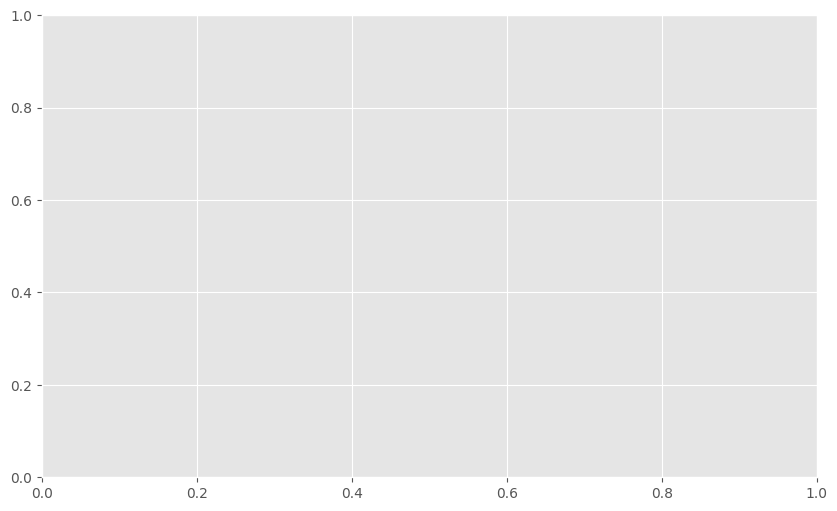

In [ ]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 6))

def exponential_smoothing(data, alpha=0.1):
    """Compute exponential smoothing."""
    smoothed = [data[0]]  # Initialize with the first data point
    for i in range(1, len(data)):
        st = alpha * data[i] + (1 - alpha) * smoothed[-1]
        smoothed.append(st)
    return smoothed

def live_plot(data_dict, ylabel="Total Rewards"):
    """Plot the live graph."""
    clear_output(wait=True)
    ax.clear()
    for label, data in data_dict.items():
        if label == "Total Reward":
            ax.plot(data, label=label, color="yellow", linestyle='--')

            # Compute and plot moving average for total reward
            ma = exponential_smoothing(data)
            ma_idx_start = len(data) - len(ma)
            ax.plot(range(ma_idx_start, len(data)), ma, label="Smoothed Value", linestyle="-", color="purple", linewidth=2)
        else:
            ax.plot(data, label=label)
    ax.set_ylabel(ylabel)
    ax.legend(loc='upper left')
    display(fig)

### train, logging

### clean up the home folder

In [ ]:

from stable_baselines3 import PPO
import numpy as np
from stable_baselines3.common.callbacks import BaseCallback
import time
import logging
import imageio
import pygame

!rm *.gif
!rm *.txt

# Remove all existing handlers (especially from Jupyter)
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

logging.basicConfig(
    filename="/content/sokoban_log.txt",  # Change path as needed
    filemode='a',                         # Append mode
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

# Before you can make a Sokoban Environment you need to call:
# import gym_sokoban
# This import statement registers all Sokoban environments
# provided by this package


'''
This info is just for your reference. Easier to know what the number means. The info is copied from sokoban_env.py
ACTION_LOOKUP = {
    0: 'no operation',
    1: 'push up',
    2: 'push down',
    3: 'push left',
    4: 'push right',
    5: 'move up',
    6: 'move down',
    7: 'move left',
    8: 'move right',
}
'''

# this class is only responsible for logging
class LoggingCallback(BaseCallback):
    """Logs rewards, actions, and states at each step"""
    def __init__(self, verbose=0):
        super().__init__(verbose)
        self.rewards_trend = []
        self.observations = []
        self.verbose = verbose
        self.episode_success = 0
        self.episode_counter = 0


    def _on_step(self) -> bool:
        """Called at each training step"""
        # for convenience, although it is batch training, we only log and visualize the first item result in the batch
        dones = self.locals['dones']
        infos = self.locals['infos']

        # we only save first episode' (of the whole batch) observation to GIF or PyGame
        # observation = self.locals['new_obs'][0]
        image_observation = infos[0]['image_observation']
        self.observations.append(image_observation)

        for i in range(len(dones)):
            if dones[i] == True:
                self.episode_counter += 1
                self.rewards_trend.append(infos[i]['episode']['l'])

                if infos[i]['success'] is True:
                    self.episode_success += 1
                    logging.info(f"success for env {i}! ")

                logging.info(f"Total steps for env {i}: {infos[i]['episode']['l']}, Total Reward for this episode: {infos[i]['episode']['r']}")

                if self.verbose:
                    print(f"Step: {infos[i]['episode']['r']}, Total Reward for this episode: {infos[i]['episode']['l']}")
                    print("returned raw info:", infos[i])

                timestr = time.strftime("%Y%m%d-%H%M%S")
                if self.episode_counter % 10 == 0:
                    create_gif(self.observations.copy(), filename="sokoban" + timestr + ".gif", success=infos[0]["success"], is_maxsteps=infos[0]["maxsteps_used"])
                    if len(self.rewards_trend) > 1:
                        live_plot({'Total Reward': self.rewards_trend})

                # if self.episode_counter % 3 == 0:
                #     pygame_replay_training_episode(self.observations, success=self.episode_success, maxsteps_used=infos[i]['episode']['l'])
                self.observations = []

        return True  # Continue training

    def get_logs(self):
        return {"rewards": self.rewards_trend, "observations": self.observations}



total_reward_trend = []
total_steps = 0

# this class is only responsible for logging
class CurriculumLoggingCallback(BaseCallback):
    """Logs rewards, actions, and states at each step"""
    def __init__(self, env, threshold=0.8, verbose=0):
        super().__init__(verbose)
        self.rewards_trend = []
        self.observations = []
        self.env = env
        self.verbose = verbose
        self.threshold = threshold
        self.episode_success = {}
        self.episode_counter = 0

    def _on_step(self) -> bool:
        """Called at each training step"""
        # for convenience, although it is batch training, we only log and visualize the first item result in the batch
        dones = self.locals['dones']
        infos = self.locals['infos']

        ### for real-time game display, we only save first episode' (of the whole batch) observation to GIF or PyGame
        # observation = self.locals['new_obs'][0]
        image_observation = infos[0]['image_observation']
        self.observations.append(image_observation)

        # C: Currently, not implement parallelism. dones only contain one item. Write in this way to use parallel env in future
        for i in range(len(dones)):
            if dones[i] == True:
                self.rewards_trend.append(infos[i]['episode']['r'])
                self.episode_counter += 1

                map_filename = infos[i]['map_filename']

                self.episode_success[map_filename] = self.episode_success.get(map_filename, 0) + 1

                timestr = time.strftime("%Y%m%d-%H%M%S")
                if self.episode_counter % 10 == 0:
                    create_gif(self.observations, "sokoban" + timestr + ".gif", infos[0]['success'], infos[0]['maxsteps_used'])

                # if self.episode_counter % 3 == 0:
                #     pygame_replay_training_episode(self.observations, infos[0]['success'], infos[0]['maxsteps_used'])

                logging.info(f"Total steps for env {i}: {infos[i]['episode']['l']}, Total Reward for this episode: {infos[i]['episode']['r']}")

                # assuming each level has 20 maps
                if infos[i]['success'] is True:
                    logging.info(f"success for env {i}! ")
                    if len(self.episode_success.keys()) >= self.threshold * 20:

                        logging.info(f"level {self.env.current_level} success number: {self.episode_success} has exceeded {self.threshold}, enter into the next level!")
                        print(f"level {self.env.current_level} success rate has exceeded {self.threshold}, enter into the next level!")
                        self.episode_success = 0
                        self.episode_counter = 0
                        self.env.advance()
                        if getattr(self.env, 'training_done', False):
                            print("Stopping training: curriculum complete.")
                            return False  # Returning False stops training

                if self.verbose:
                    print(f"Total steps for env {i}: {infos[i]['episode']['l']}, Total Reward for this episode: {infos[i]['episode']['r']}")
                    print("returned raw info:", infos[i])

                timestr = time.strftime("%Y%m%d-%H%M%S")
                if self.episode_counter % 10 == 0:
                    create_gif(self.observations.copy(), filename="sokoban" + timestr + ".gif", success=infos[i]['success'], is_maxsteps=infos[i]['episode']['l'])
                    if len(self.rewards_trend) > 0:
                        live_plot({'Total Reward': self.rewards_trend})

                # if self.episode_counter % 3 == 0:
                #     pygame_replay_training_episode(self.observations, success=self.episode_success, maxsteps_used=infos[i]['episode']['l'])
                self.observations = []


        return True  # Continue training

    def get_logs(self):
        live_plot({'Total Reward': self.rewards_trend})
        total_reward_trend.extend(self.rewards_trend)
        return {"current_level": self.env.current_level, "episode_success": self.episode_success}





rm: cannot remove '*.gif': No such file or directory


## Training

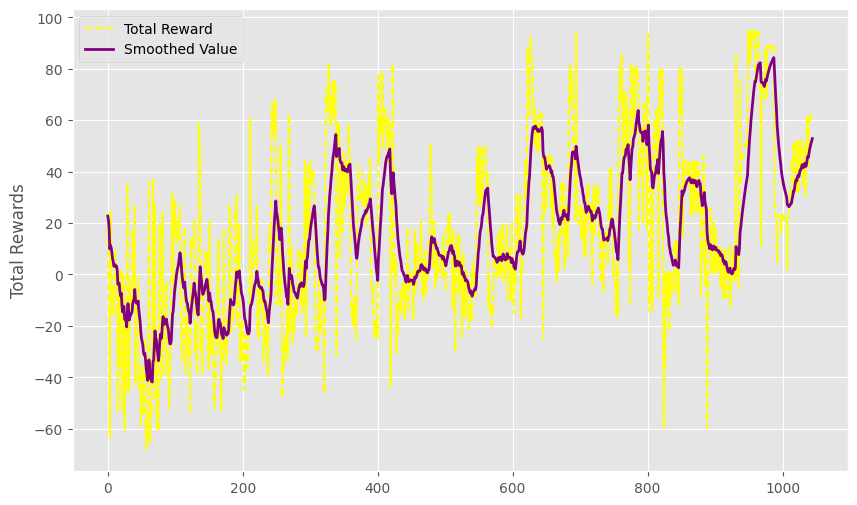

Algorithm ends because reaching total_timesteps! The current level is 2, and current episode success rate: {'': 1045}. Now save model.


In [ ]:
!rm *.gif
from stable_baselines3.common.vec_env import DummyVecEnv

## *******************************************************************************

# env = CustomizeSokobanEnv(max_steps=300, verbose=False)
steps = 100000
total_steps = steps
env = CurriculumSokobanEnv(2, 4,  num_boxes = 3, verbose=False, max_steps = 100)
observation = env.reset()
ACTION_LOOKUP = env.get_action_lookup()


# Attach the callback when training the model
callback = CurriculumLoggingCallback(env, verbose=0)

policy_kwargs = dict(
    net_arch=[dict(pi=[256, 256], vf=[256, 256])]
)

model = PPO("MlpPolicy", env,
                n_steps=2048,             # Should be a multiple of vec_envs (if used)
                batch_size=32,            # Smaller batch size may help with stability
                gae_lambda=0.95,
                gamma=0.99,
                n_epochs=10,
                learning_rate=1e-4,
                clip_range=0.2,
                policy_kwargs=policy_kwargs,
                verbose=1)
# model = PPO.load("ppo_sokoban", env=env)
model.learn(total_timesteps=steps, callback=callback)  # Adjust the timesteps as needed
logs = callback.get_logs()

print(f"Algorithm ends because reaching total_timesteps! The current level is {logs['current_level']}, and current episode success rate: {logs['episode_success']}. Now save model.")

# uncomment the code to save the model
timestr = time.strftime("%Y%m%d-%H%M%S")
model.save(base_dir + "/" + "sokoban_agent_" + timestr)

## *******************************************************************************


    # 0: 'no operation',
    # 1: 'push up',
    # 2: 'push down',
    # 3: 'push left',
    # 4: 'push right',
    # 5: 'move up',
    # 6: 'move down',
    # 7: 'move left',
    # 8: 'move right',

## Continue training

In [ ]:
!rm *.gif

from stable_baselines3.common.monitor import Monitor

steps = 10000
total_steps += steps
env = CurriculumSokobanEnv(2, 4,  num_boxes = 3, verbose=False, max_steps = 100)
observation = env.reset()
ACTION_LOOKUP = env.get_action_lookup()

# Attach the callback when training the model
callback = CurriculumLoggingCallback(env, verbose=0)

policy_kwargs = dict(
    net_arch=[dict(pi=[256, 256], vf=[256, 256])]
)

# follow the above step, load the last model and then continue training
model = PPO.load(base_dir + "/" + "sokoban_agent_" + timestr, env=env,
                      n_steps=2048,             # Should be a multiple of vec_envs (if used)
                        batch_size=32,            # Smaller batch size may help with stability
                        gae_lambda=0.95,
                        gamma=0.99,
                        n_epochs=5,
                        learning_rate=1e-4,
                        clip_range=0.2,
                        verbose=1)
model.learn(total_timesteps=steps, callback=callback)  # Adjust the timesteps as needed
logs = callback.get_logs()

print(f"Algorithm ends because reaching total_timesteps! The current level is {logs['current_level']}, and current episode success rate: {logs['episode_success']}. Now save model.")

# uncomment the code to save the model
timestr = time.strftime("%Y%m%d-%H%M%S")
model.save(base_dir + "/" + "sokoban_agent_" + timestr)


##  train with deepmind dataset

In [ ]:
!rm *.gif
from stable_baselines3.common.vec_env import DummyVecEnv

## *******************************************************************************

# env = CustomizeSokobanEnv(max_steps=300, verbose=False)
steps = 10000
total_steps = steps
env = CustomizeSokobanEnv(num_boxes = 4, verbose=False, max_steps = 100)
observation = env.reset()
ACTION_LOOKUP = env.get_action_lookup()

# Attach the callback when training the model
callback = LoggingCallback(verbose=0)

model = PPO("MlpPolicy", env,
                n_steps=2048,             # Should be a multiple of vec_envs (if used)
                batch_size=64,            # Smaller batch size may help with stability
                gae_lambda=0.95,
                gamma=0.99,
                n_epochs=10,
                learning_rate=3e-4,
                clip_range=0.2,
                verbose=1)
# model = PPO.load("ppo_sokoban", env=env)
model.learn(total_timesteps=steps, callback=callback)  # Adjust the timesteps as needed
logs = callback.get_logs()

print(f"Algorithm ends because reaching total_timesteps! and current episode success rate: {logs['episode_success']}. Now save model.")

# uncomment the code to save the model
timestr = time.strftime("%Y%m%d-%H%M%S")
model.save(base_dir + "/" + "sokoban_agent_" + timestr)

## *******************************************************************************